In [1]:
#Importing Packages
import numpy as np
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import tinygp_2process_model
from src.examples_functions import realisations_2process
from src.examples_functions import plot_underlying_data,plotting_output_2process

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
X = jnp.arange(0,100,0.1)

sample: 100%|██████████| 3000/3000 [01:30<00:00, 33.25it/s, 15 steps of size 3.81e-01. acc. prob=0.85] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      3.37      2.01      2.93      0.57      6.10    905.72      1.00
  blengthscale      8.03      3.48      7.57      3.02     12.52    615.22      1.00
         bmean     -1.06      0.84     -1.07     -2.36      0.34   1039.51      1.00
      kern_var      1.92      0.57      1.84      1.13      2.88    713.84      1.00
   lengthscale      2.93      0.08      2.94      2.81      3.06    724.86      1.00
          mean      1.13      0.44      1.14      0.44      1.86   1146.67      1.00

Number of divergences: 15
Time Taken: 90.95526936277747


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


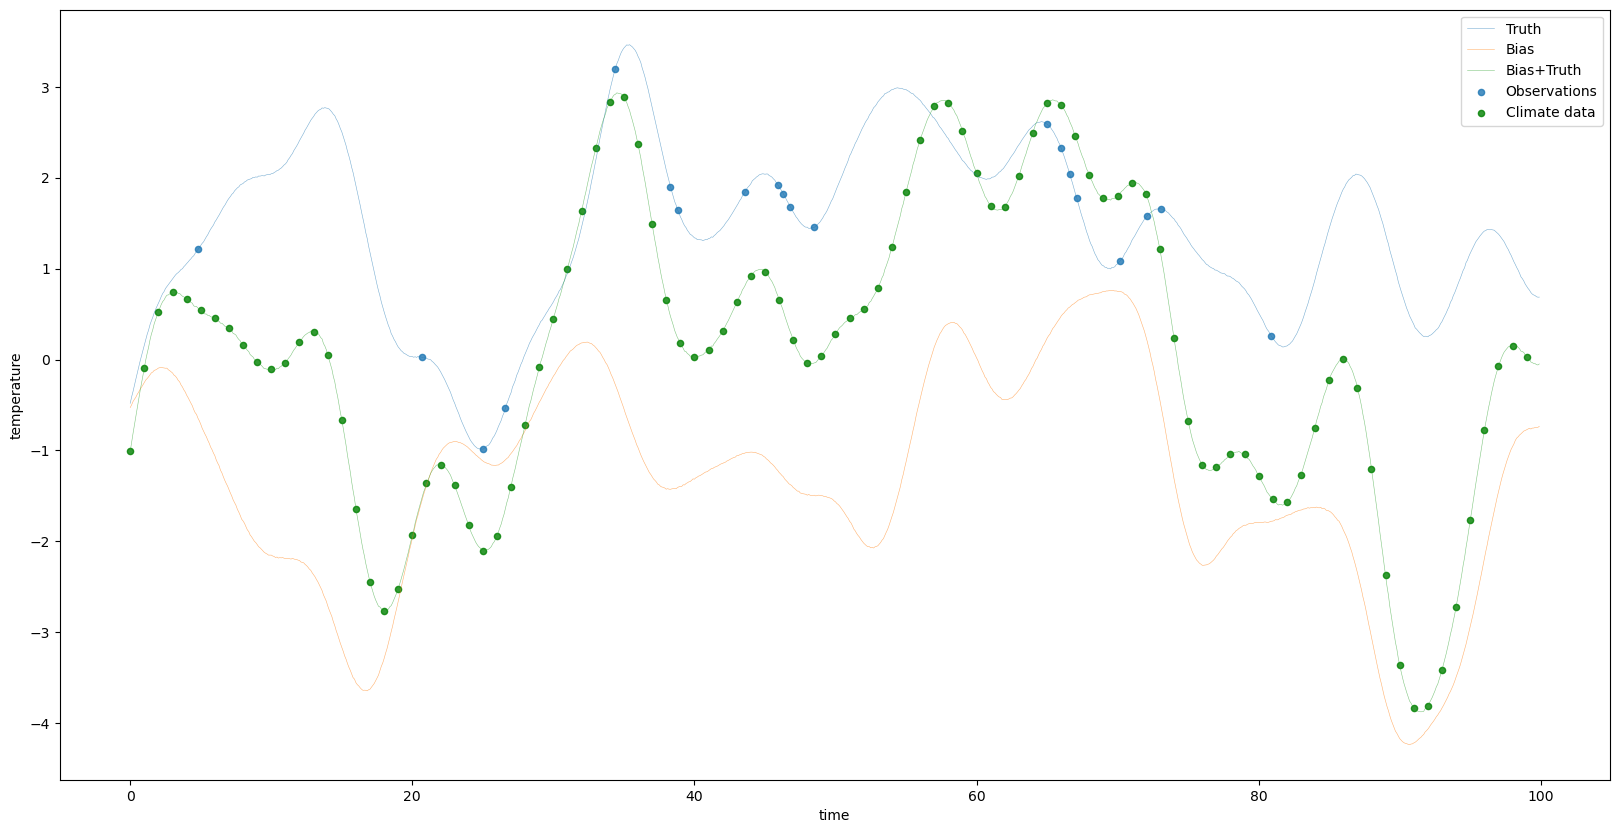

<Figure size 2000x1000 with 0 Axes>

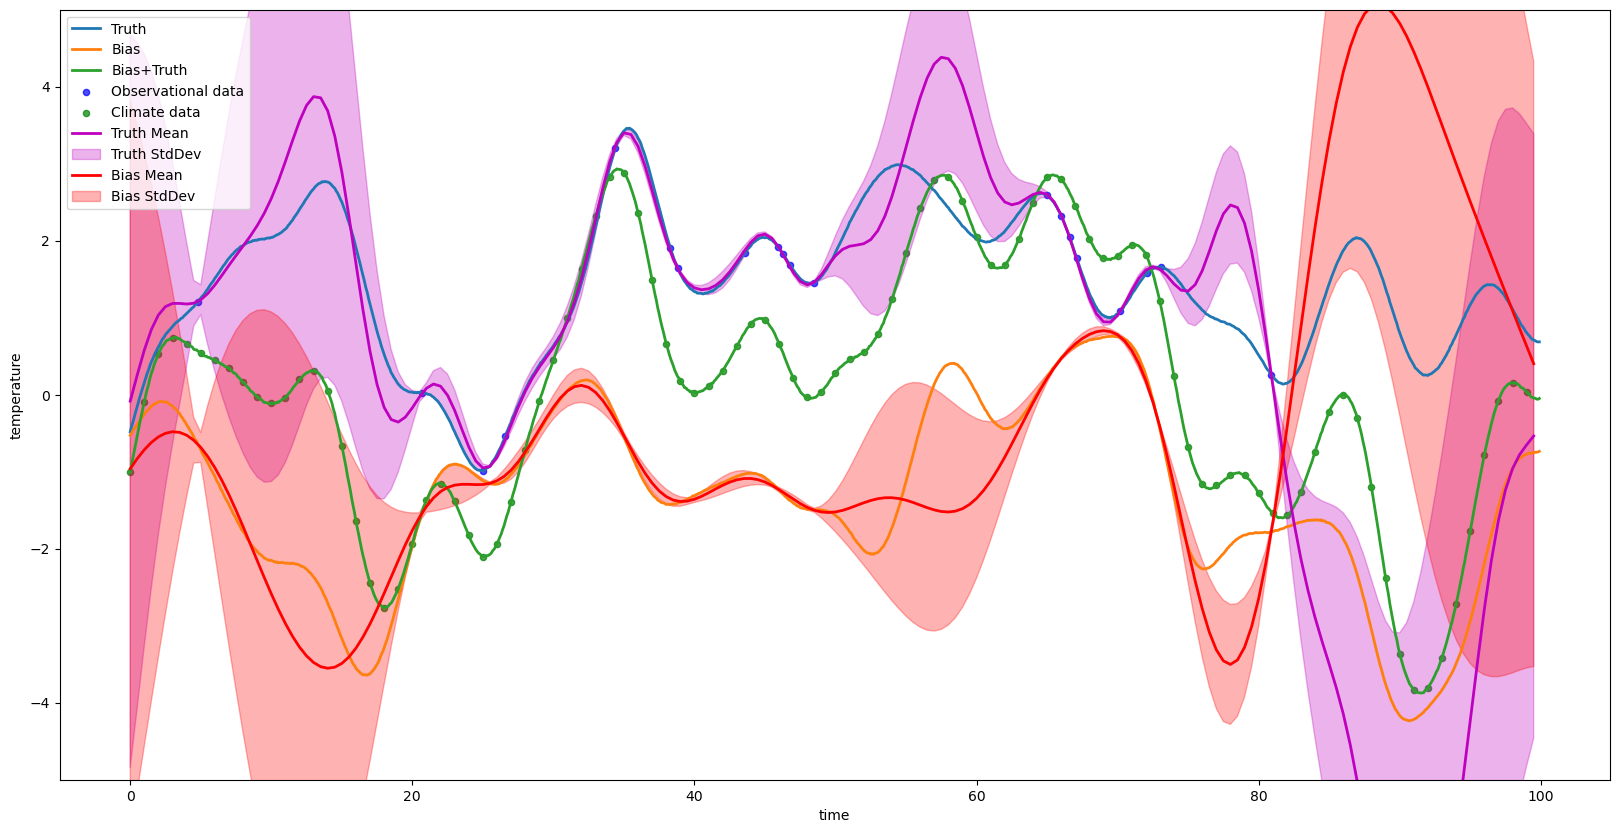

In [4]:
# Scenario: Similar Lengthscales, Sparse Observations
onoise=1e-5
bnoise=1e-5
cnoise=1e-5
jitter=1e-5

GP = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=onoise,mean=1.0)
Y = GP.sample(rng_key)

GP2 = GaussianProcess(1 * kernels.ExpSquared(3),X,diag=bnoise,mean=-1.0)
rng_key, rng_key_ = random.split(rng_key)
Y2 = GP2.sample(rng_key)

cx = X[::10] 
cdata = (Y+Y2)[::10] 
osample = np.random.choice(range(X.size), size=int(0.2*cx.size), replace=False)
ox = X[osample]
odata = Y[osample]

plot_underlying_data(X,Y,Y2,ox,odata,cx,cdata,fs=(20,10),ms=20)

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx,ox=ox,cdata=cdata,odata=odata,onoise=onoise,cnoise=cnoise)
idata_2process = az.from_numpyro(mcmc_2process)
nx = X[::5] # locations where predictions will be made

truth_realisations,bias_realisations = realisations_2process(
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,20,20)

plt.figure(figsize=(20,10))
ylims = [truth_realisations.min(),truth_realisations.max()]
plotting_output_2process(X,Y,Y2,ox,odata,cx,cdata,
                         truth_realisations,bias_realisations,nx,
                         fs=(20,10),ms=20,ylims=[-5,5])